In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from numpy import linalg as LA
import numpy.matlib as npm

C:\Users\Admin\AppData\Local\Temp\ipykernel_12976\2664275264.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Loading Dataset
df = pd.read_csv(r'C:\Users\Admin\Desktop\winequality-white.csv',delimiter=";")
Data = df.to_numpy()

N = Data.shape[0]       # Number of Samples
label = Data[:, 11]     # Extracting labels from dataset
Data = Data[:, 0:11]    # Feature set
label_count = 11
feature_count = 11      
meanMatrix = np.zeros(shape = [label_count, feature_count])
covarianceMatrix = np.zeros(shape = [label_count, feature_count, feature_count])

In [3]:
# Calculating Mean Vectors and Covariance matrices from dataset
for i in range(0, label_count):
    meanMatrix[i, :] = np.mean(Data[(label == i)], axis = 0)
    # Identity covariance matrix for labels not in dataset 
    if (i not in label):
        covarianceMatrix[i, :, :] = np.eye(feature_count)
    else:
        covarianceMatrix[i, :, :] = np.cov(Data[(label == i), :], rowvar = False)
        covarianceMatrix[i, :, :] += (0.000000005) * ((np.trace(covarianceMatrix[i, :, :]))/LA.matrix_rank(covarianceMatrix[i, :, :])) * np.eye(feature_count)  # applying regularization
   
    #print(LA.cond(covarianceMatrix[i,:,:]))

# print(meanMatrix.shape)
# print(covarianceMatrix.shape)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [4]:
lossMatrix = np.ones(shape = [label_count, label_count]) - np.eye(label_count)

P_x_L = np.zeros(shape = [label_count, N])
for i in range(0, label_count):
    if i in label:
        P_x_L[i, :] = multivariate_normal.pdf(Data, mean = meanMatrix[i, :], cov = covarianceMatrix[i, :,:])

# Estimate class priors based on sample count
priors = np.zeros(shape = [11, 1])
for i in range(0, label_count):
    priors[i] = (np.size(label[np.where((label == i))])) / N

# Compute Class Posteriors using priors and class conditional PDF
P_x = np.matmul(np.transpose(priors), P_x_L)
ClassPosteriors = (P_x_L * (np.matlib.repmat(priors, 1, N))) / np.matlib.repmat(P_x, label_count, 1)

In [8]:
# expected risk and decisions based on minimum risk
expectedRisk = np.matmul(lossMatrix, ClassPosteriors)
decision = np.argmin(expectedRisk, axis = 0)
print("Average Expected Risk", np.sum(np.min(expectedRisk, axis = 0)) / N)

# calculating Confusion Matrix
ConfusionMatrix = np.zeros(shape = [label_count, label_count])
for d in range(label_count):
    for l in range(label_count):
        if l in label and d in label:
            ConfusionMatrix[d, l] = (np.size(np.where((d == decision) & (l == label)))) / np.size(np.where(label == l))

np.set_printoptions(precision=3, suppress=True)
print(ConfusionMatrix)

Average Expected Risk 0.38565999041584
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.35  0.018 0.007 0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.1   0.245 0.032 0.01  0.002 0.011 0.    0.   ]
 [0.    0.    0.    0.2   0.399 0.501 0.181 0.025 0.011 0.    0.   ]
 [0.    0.    0.    0.25  0.258 0.351 0.44  0.24  0.28  0.    0.   ]
 [0.    0.    0.    0.1   0.08  0.108 0.361 0.72  0.629 0.    0.   ]
 [0.    0.    0.    0.    0.    0.001 0.007 0.013 0.069 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


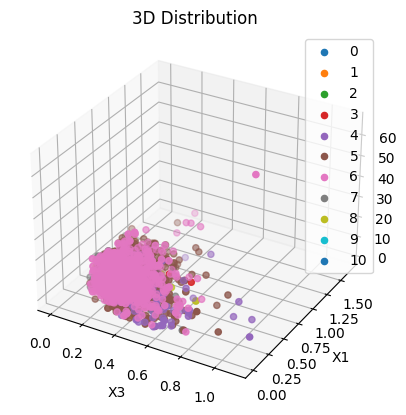

In [6]:
# Plot Data Distribution
fig = plt.figure()
ax = plt.axes(projection = "3d")
for i in range(label_count):
    ax.scatter(Data[(label==i),1],Data[(label==i),2],Data[(label==i),3], label=i)
plt.xlabel('X3')
plt.ylabel('X1')
ax.set_zlabel('X2')
ax.legend()
plt.title('3D Distribution')
plt.show()